# 你的客户到底多有价值？
---
### 客户终身价值分析🤑🤑🤑🤑🤑🤑








## 介绍
Customer Lifetime Value（CLTV） is a business metric that measures how much a business can plan to earn from the average customer over the course of the relationship.     Differences in products, costs, purchase frequencies and purchase volumes can make customer lifetime value calculations complex. 
 
When measuring CLV, it’s best to look at the total average revenue generated by a customer and the total average profit.  Each provides important insights into how customers interact with your business and if your overall marketing plan is working as expected. 


## 形式
> CLTV = 平均交易规模 x 交易数量 x 保留期

> CLTV = 预期交易次数 * 预期利润

* BG / NBD = Expected Transaction
* Gamma Gamma = Expected Profit

## 目录：
1.   问题提出

    *   数据集来源
    *   数据集变量

2.   包
3.   加载和检查数据

    *   数据预处理
    *   异常值检查
    *   类别转换
4.   探索性数据分析

    *   类别变量
    *   数值变量
5.   数据准备
6.   BG-NBD模型
    *   预测
7.   Gamma Gamma模型
8.   Customer lifetime value
9.   CLTV预测的细分
9.   参考文献



## 问题提出
### 数据集来源

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.
https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

### 数据集变量

*   InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
*   StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
*   Description: Product (item) name. Nominal.
*   Quantity: The quantities of each product (item) per transaction. Numeric.
*   InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
*   UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
*   CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
*   Country: Country name. Nominal. The name of the country where a customer resides.




## 包

In [2]:
# installlation required
!pip install Lifetimes #python自带计算cltv
!pip install plotly

# libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter #Basic Frequency/Recency analysis using the BG/NBD model
from lifetimes import GammaGammaFitter #Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler#Transform features by scaling each feature to a given range.
import warnings 
warnings.filterwarnings("ignore")
import plotly.express as px
import numpy as np

import datetime
import plotly.graph_objects as go

from lifetimes.plotting import plot_frequency_recency_matrix#可视化频率矩阵，上次购买的时刻和频率（重复交易的数量）
from lifetimes.plotting import plot_probability_alive_matrix#客户是否还活着
from lifetimes.plotting import plot_period_transactions#模型评估效果检查
from lifetimes.utils import calibration_and_holdout_data#交叉验证
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases#绘制模型交叉验证图

## 加载和检查数据

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Online Retail II Data Set from ML Repository/Year 2010-2011.csv',encoding='unicode_escape')
df.head()

Invoice StockCode  ... Customer ID         Country
0  536365    85123A  ...     17850.0  United Kingdom
1  536365     71053  ...     17850.0  United Kingdom
2  536365    84406B  ...     17850.0  United Kingdom
3  536365    84029G  ...     17850.0  United Kingdom
4  536365    84029E  ...     17850.0  United Kingdom

[5 rows x 8 columns]

In [4]:
len(df)

541910

### 数据预处理

#### 非法值处理

In [5]:
#去除含有C的表示中止操作的发票 和为空的发票(字符串的模糊筛选)
data= df[~df['Invoice'].str.contains('C',na=False)]

In [6]:
#买的量和价钱不能为小于0 所以去除掉
print((data.Quantity < 0).value_counts())
print((data.Price < 0).value_counts())

False    531286
True       1336
Name: Quantity, dtype: int64
False    532620
True          2
Name: Price, dtype: int64


In [7]:
data.query('Quantity > 0 & Price > 0',inplace=True)

#### 缺失值处理

In [8]:
data.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    132220
Country             0
dtype: int64

In [9]:
data.dropna(inplace=True)#不返回东西，只修改data里的值
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [10]:
data.describe()
#这里我们看到ID也被当成数值型数据了 后面要进行处理一下

Quantity          Price    Customer ID
count  397885.000000  397885.000000  397885.000000
mean       12.988208       3.116525   15294.416882
std       179.331551      22.097861    1713.144421
min         1.000000       0.001000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000

### 异常值处理

In [11]:
#观察两个数值型变量的列是否有异常值
fig = px.box(y=data['Quantity'], notched=True)
fig.show()

fig = px.box(y=data['Price'], notched=True)
fig.show()

In [12]:
#对异常值进行修改 超过上界or下界就直接把数值归为上界or下界
def two_bound(df,var):
  res = np.percentile(df[var],(1,99),interpolation='midpoint')
  #上四分位数
  quartile1 = res[0]
  #下四分位数
  quartile3 = res[1]
  
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

def replace_bound(df, var):
    low_limit, up_limit = two_bound(df, var)
    df.loc[(df[var] < low_limit), var] = low_limit
    df.loc[(df[var] > up_limit), var] = up_limit

replace_bound(data,'Quantity')
replace_bound(data,'Price')

### 类别转换

In [13]:
#把Customer ID转换为类别型变量
print(data['Customer ID'].dtypes)
data['Customer ID']=data['Customer ID'].astype(int)
data['Customer ID']=data['Customer ID'].astype(str)
print(data['Customer ID'].dtypes)

float64
object


In [14]:
data = data.reset_index()
del data['index']

In [15]:
#把时间的那个字段转化成时间戳的形式
datatime = []
for i in range(0,len(list(data['InvoiceDate']))):
  temp = data['InvoiceDate'][i]
  dateTime_p = datetime.datetime.strptime(temp,'%m/%d/%Y %H:%M')
  datatime.append(dateTime_p)

data['InvoiceDate']=datatime

## 探索性数据分析

### 类别变量

In [16]:
cat_cols = [col for col in data.columns if data[col].dtypes =="O"]
cat_cols

['Invoice', 'StockCode', 'Description', 'Customer ID', 'Country']

In [17]:
#先算出现的频数
for col_name in cat_cols:
  print(pd.DataFrame({col_name:data[col_name].value_counts(),
            '比率':100 * data[col_name].value_counts()/len(data)}))

        Invoice        比率
576339      542  0.136220
579196      533  0.133958
580727      529  0.132953
578270      442  0.111087
573576      435  0.109328
...         ...       ...
555385        1  0.000251
574666        1  0.000251
580068        1  0.000251
576691        1  0.000251
569084        1  0.000251

[18532 rows x 2 columns]
        StockCode        比率
85123A       2035  0.511454
22423        1723  0.433040
85099B       1618  0.406650
84879        1408  0.353871
47566        1396  0.350855
...           ...       ...
22125           1  0.000251
20667           1  0.000251
37461           1  0.000251
90129E          1  0.000251
90011A          1  0.000251

[3665 rows x 2 columns]
                                     Description        比率
WHITE HANGING HEART T-LIGHT HOLDER          2028  0.509695
REGENCY CAKESTAND 3 TIER                    1723  0.433040
JUMBO BAG RED RETROSPOT                     1618  0.406650
ASSORTED COLOUR BIRD ORNAMENT               1408  0.353871
PARTY 

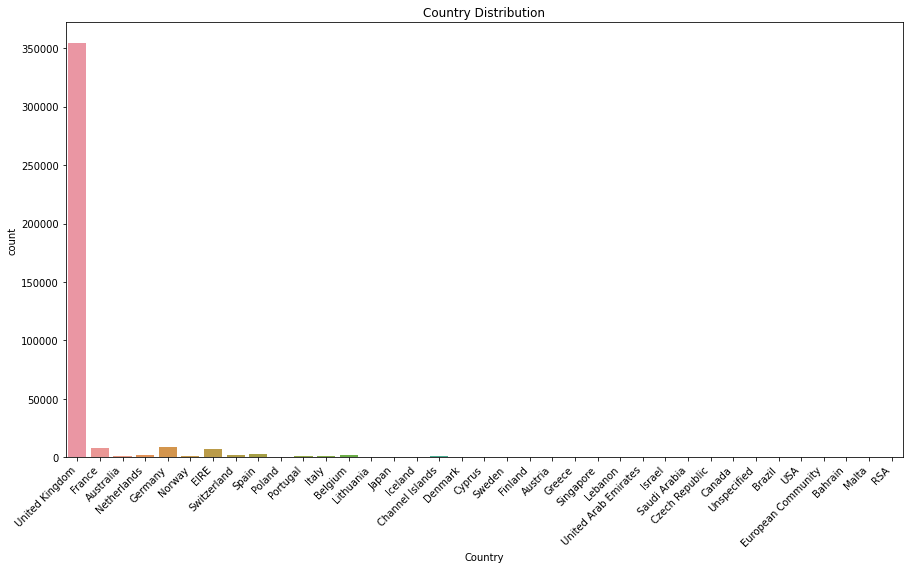

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x=data['Country'], data=data)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Country Distribution')
plt.show()

In [19]:
#每个描述对应的销售量 也就是可以理解为一种类型物品的销售量
sale_product = data.groupby('Description').agg({'Quantity':'sum'})
sale_product.reset_index(inplace=True)
sale_product

Description  Quantity
0        4 PURPLE FLOCK DINNER CANDLES     140.0
1        50'S CHRISTMAS GIFT BAG LARGE    1783.5
2                    DOLLY GIRL BEAKER    2195.0
3          I LOVE LONDON MINI BACKPACK     360.0
4          I LOVE LONDON MINI RUCKSACK       1.0
...                                ...       ...
3872   ZINC T-LIGHT HOLDER STARS SMALL    4894.0
3873    ZINC TOP  2 DOOR WOODEN SHELF       10.0
3874  ZINC WILLIE WINKIE  CANDLE STICK    2607.0
3875       ZINC WIRE KITCHEN ORGANISER      25.0
3876  ZINC WIRE SWEETHEART LETTER TRAY      80.0

[3877 rows x 2 columns]

In [20]:
#销售订单数 一种类型物品的销售量
sale_num = data.groupby('Description').agg({'Quantity':'count'})
sale_num.reset_index(inplace=True)
sale_num

Description  Quantity
0        4 PURPLE FLOCK DINNER CANDLES        39
1        50'S CHRISTMAS GIFT BAG LARGE       109
2                    DOLLY GIRL BEAKER       138
3          I LOVE LONDON MINI BACKPACK        70
4          I LOVE LONDON MINI RUCKSACK         1
...                                ...       ...
3872   ZINC T-LIGHT HOLDER STARS SMALL       238
3873    ZINC TOP  2 DOOR WOODEN SHELF          9
3874  ZINC WILLIE WINKIE  CANDLE STICK       192
3875       ZINC WIRE KITCHEN ORGANISER        12
3876  ZINC WIRE SWEETHEART LETTER TRAY        20

[3877 rows x 2 columns]

In [21]:
#销售量top 20
top20 = sale_product.sort_values(by='Quantity',ascending = False).head(20)
fig = go.Figure(data=[go.Bar(x=top20['Description'], y=top20['Quantity'], text=top20['Quantity'], textposition='auto',marker_color=['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure',
            'beige', 'bisque', 'black', 'blanchedalmond', 'blue',
            'blueviolet', 'brown', 'burlywood', 'cadetblue',
            'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
            'cornsilk', 'crimson'])])
fig.show()

### 数值变量

In [22]:
num_cols = [col for col in data.columns if data[col].dtypes != 'O']
num_cols

['Quantity', 'InvoiceDate', 'Price']

count    397885.000000
mean         11.830770
std          25.523052
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max         298.500000
Name: Quantity, dtype: float64


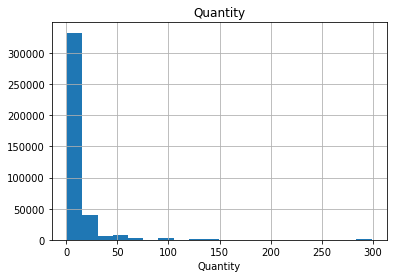

count    397885.000000
mean          2.893492
std           3.227175
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max          37.060000
Name: Price, dtype: float64


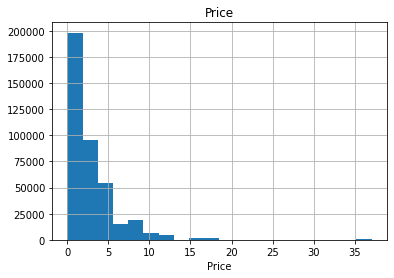

In [23]:
#Date这个部分就不做另外分析了 很明显可以看出是从2010-12到2011-12
for col_name in num_cols:
  if col_name != 'InvoiceDate':
    print(data[col_name].describe())
    data[col_name].hist(bins=20)
    plt.xlabel(col_name)
    plt.title(col_name)
    plt.show()

In [24]:
#每笔发票的总金额
data["TotalPrice"] = data["Price"] * data["Quantity"]

## 数据准备
- recency：客户上一次购买和第一次购买的差异
- T：客户的时间(购买年龄)
- frequency：重复购买的总次数
- monetary_value：每次购买的平均收益

In [25]:
cltv_df = summary_data_from_transaction_data(data,'Customer ID','InvoiceDate',
                        monetary_value_col='TotalPrice',
                        observation_period_end='2011-12-9',
                        freq='D')

In [26]:
cltv_df.head()

frequency  recency      T  monetary_value
Customer ID                                           
12346              0.0      0.0  325.0        0.000000
12347              6.0    365.0  367.0      599.701667
12348              3.0    283.0  358.0      298.540000
12349              0.0      0.0   18.0        0.000000
12350              0.0      0.0  310.0        0.000000

In [27]:
temp_list=list(set(list(cltv_df['frequency'])))
temp_count=[0]*len(temp_list)
for i in range(0,len(list(cltv_df['frequency']))):
  index=temp_list.index(list(cltv_df['frequency'])[i])
  temp_count[index]+=1
#频率分布
fig = go.Figure(data=[go.Bar(x=temp_list,y=temp_count,text=temp_count,textposition='auto',marker_color='pink')])
fig.show()

## BG-NBD 模型
>贝塔几何/负二项模型，用于描述非契约客户关系情境下重复购买行为
                       #Buy
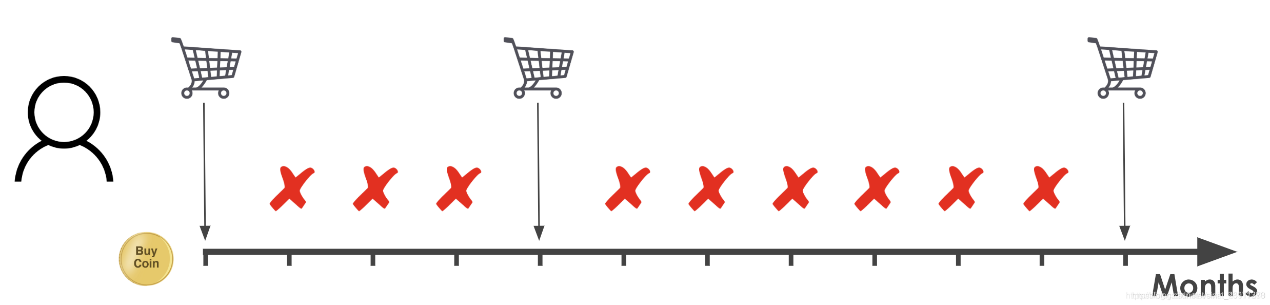
                       #Till you die
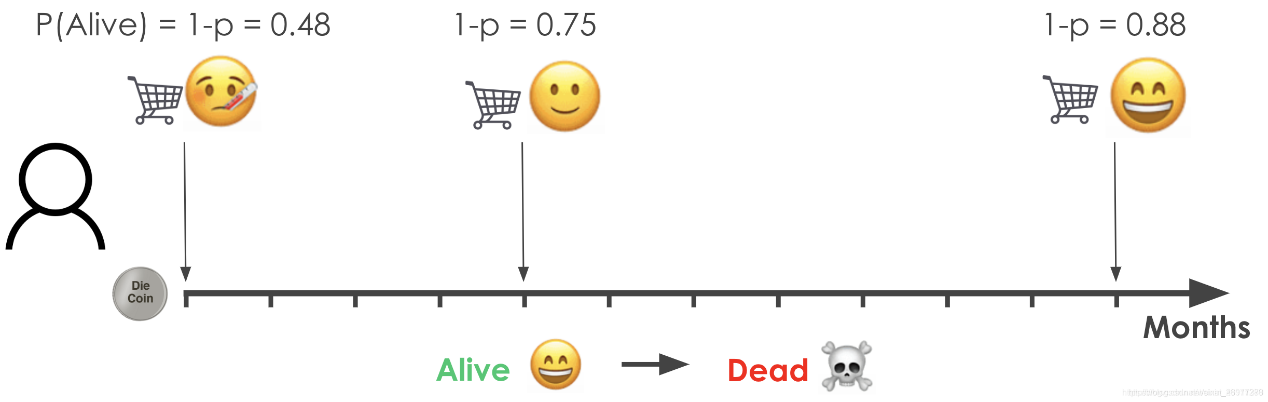
#### Buy Till You Die

Two processes for the Expected Number of Transaction.预期交易数
> Transaction Process (Buy) + Dropout Process (Till You Die)

#### Transaction Process (Buy)
* As long as it is alive, the number of transactions to be performed by a client in a given time period is poisson distributed with the transaction rate parameter.
* As long as a customer is alive, they will continue to make random purchases around their transaction rate.
* Transaction rates vary according to each customer. They are **gamma dispersed** for the entire audience (r, a).


So the buy process of the BG/NBD model indicates; I am modeling the purchasing activity of the whole audience with the gamma distribution. 

#### Dropout Process (Till You Die)
* Each customer has a dropout rate (dropout probability) with probability p.
* A customer drops with a certain probability after making a purchase. This is not a full churn, it may return after a certain time.
* Dropout rates vary for each client and **beta is distributed** for the entire audience (a, b).


In [28]:
#penalizer_coef 通过L2范数来控制参数的大小
bgf = BetaGeoFitter(penalizer_coef=0.000001)
bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.92, b: 2.96, r: 0.83>


In [29]:
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r       0.826721  0.026801         0.774191         0.879251
alpha  68.923877  2.618577        63.791465        74.056288
a       0.001860  0.006000        -0.009900         0.013619
b       2.963947  6.261420        -9.308435        15.236329

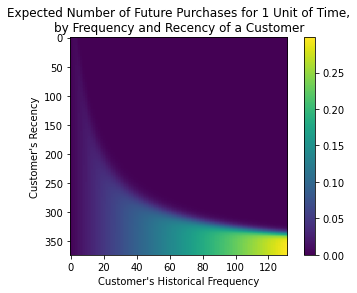

In [30]:
#可视化频率矩阵
plot_frequency_recency_matrix(bgf)

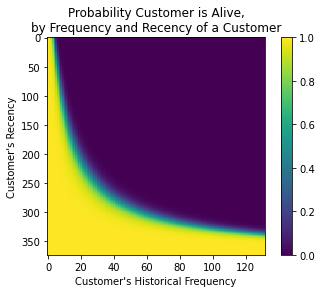

In [31]:
#仍然活着的概率
plot_probability_alive_matrix(bgf)

排名他们从"在未来一个时期的最高预期购买"到最低。模型暴露了一种使用其历史记录预测客户未来一段时期预期购买情况的方法。

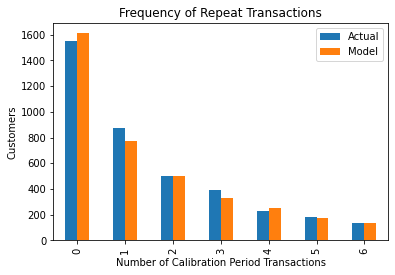

In [32]:
#评估模型的拟合效果 1.首先是将数据与模拟的人工数据与安装模型的参数进行比较。
plot_period_transactions(bgf)

In [33]:
print(min(data['InvoiceDate']))
print(max(data['InvoiceDate']))

2010-12-01 08:26:00
2011-12-09 12:50:00


In [34]:
#交叉验证
#划分验证期
val_data = calibration_and_holdout_data(data,'Customer ID','InvoiceDate',
                      calibration_period_end='2011-06-01',
                      observation_period_end='2011-12-09')
val_data.head()

frequency_cal  recency_cal  ...  frequency_holdout  duration_holdout
Customer ID                              ...                                     
12346                  0.0          0.0  ...                0.0             191.0
12347                  2.0        121.0  ...                4.0             191.0
12348                  2.0        110.0  ...                1.0             191.0
12350                  0.0          0.0  ...                0.0             191.0
12352                  3.0         34.0  ...                3.0             191.0

[5 rows x 5 columns]

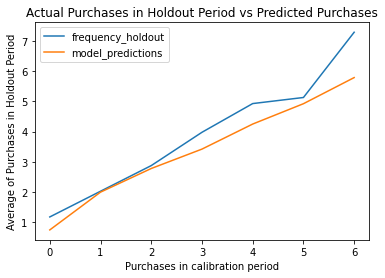

In [35]:
bgf.fit(val_data['frequency_cal'],val_data['recency_cal'],val_data['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf,val_data)

样本期间从开始到2011-06-01; 验证期从2011-06-01到2011-12-09。该图通过重复购买次数（x轴）对校准期内的所有客户进行分组，然后在保持期（y轴）中对其重复购买进行平均。橙线和蓝线分别表示模型预测和y轴的实际结果。正如我们所看到的，我们的模型能够非常准确地预测出样本中客户群的行为，模型略低估了3次购买后。

### 预测

In [36]:
#预测时间 用户未来t天的购买次数
t=90
cltv_df["expected"] = bgf.predict(t,cltv_df['frequency'],cltv_df['recency'],cltv_df['T'])
cltv_df.sort_values("expected", ascending=False).head(10)

frequency  recency      T  monetary_value   expected
Customer ID                                                      
14911            131.0    372.0  373.0     1057.185420  27.281727
12748            112.0    373.0  373.0      289.066607  23.346817
17841            111.0    372.0  373.0      363.957477  23.139717
15311             89.0    373.0  373.0      677.729438  18.583505
14606             88.0    372.0  373.0      135.279659  18.376405
12971             70.0    369.0  372.0      155.980929  14.682382
13089             65.0    367.0  369.0      893.580923  13.739558
14527             53.0    367.0  369.0      155.016415  11.231265
13798             52.0    371.0  372.0      705.649712  10.945974
16422             47.0    352.0  369.0      673.084468   9.977118

## Gamma-Gamma Model
>用于估计客户每笔交易平均可以产生多少利润。

*What will the gamma gamma model do? *

It will output the Expected Average Profit. This means; The Expected Average Profit distribution will be modeled over the whole audience, and the Gamma Gamma Submodel will be conditionally giving us the Expected Average Profit for a person, taking into account the distribution of the whole audience, according to the characteristics of the person himself.

我们将用来估计用户群的 CLV 的模型称为伽玛-伽玛子模型，它依赖于一个重要的假设。事实上，伽玛-伽玛子模型假定货币价值和购买频率之间没有关系。在实践中，我们需要检查两个向量之间的 Pearson 相关性，以便使用此模型。

In [37]:
cltv_df[['monetary_value', 'frequency']].corr()

monetary_value  frequency
monetary_value        1.000000   0.313821
frequency             0.313821   1.000000

这里仅仅估算至少有一次重复购买的客户

In [38]:
returing_id = cltv_df[cltv_df['frequency'] > 0]

In [39]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(returing_id['frequency'],returing_id['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 3.76, q: 0.34, v: 3.65>


In [40]:
#估算每个客户的平均交易价值(平均利润的条件期望)
returing_id["expected_average_profit"] = ggf.conditional_expected_average_profit(returing_id['frequency'],returing_id['monetary_value'])
returing_id.sort_values("expected_average_profit", ascending=False).head(20)

frequency  recency  ...  expected  expected_average_profit
Customer ID                      ...                                   
18102             25.0    367.0  ...  5.403680              8733.558156
12415             15.0    313.0  ...  3.552344              7646.791728
14646             44.0    353.0  ...  9.687533              6071.943299
15749              1.0     97.0  ...  0.396023              5308.542943
17450             26.0    359.0  ...  5.613679              5039.534024
17850              1.0      1.0  ...  0.358660              4728.166892
12435              1.0    188.0  ...  0.474367              4678.439794
16684             15.0    354.0  ...  3.374546              4124.659489
14088             11.0    312.0  ...  2.752716              3966.931910
12753              5.0    340.0  ...  1.217890              3698.763130
14096             16.0     97.0  ...  9.262772              3397.570922
17511             27.0    371.0  ...  5.743274              3322.788904
13081              8.0    360.0  ...  1.816725              3319.861229
13555              1.0    128.0  ...  0.593604              3110.682860
14156             42.0    362.0  ...  8.890698              2763.624878
12931             11.0    336.0  ...  2.522540              2746.159929
12557              4.0    355.0  ...  0.984493              2684.634867
12409              2.0    104.0  ...  1.009410              2669.691441
15032              1.0    110.0  ...  0.364532              2660.711484
16303              2.0    308.0  ...  0.623115              2487.586845

[20 rows x 6 columns]

## Customer lifetime value
**DCF method**
>Discount Cash Flow


In [41]:
cltv = ggf.customer_lifetime_value(bgf,#the model to use to predict the number of future transactions
                  cltv_df['frequency'],
                  cltv_df['recency'],
                  cltv_df['T'],
                  cltv_df['monetary_value'],
                  freq='D')
#默认算用户预期寿命为12个月的，freq是T的计算单位，贴现率0.01

In [42]:
#重设索引
cltv = cltv.reset_index()
cltv_final = cltv_df.merge(cltv,on='Customer ID',how='left')
cltv_final.sort_values(by='clv',ascending=False).head(10)

Customer ID  frequency  recency  ...  monetary_value   expected            clv
1689       14646       44.0    353.0  ...     6047.558295   9.687533  220682.624509
4201       18102       25.0    367.0  ...     8671.891800   5.403680  177054.934677
1289       14096       16.0     97.0  ...     3359.947500   9.262772  118069.228846
1879       14911      131.0    372.0  ...     1057.185420  27.281727  108354.243778
3728       17450       26.0    359.0  ...     5005.259808   5.613679  106136.613341
55         12415       15.0    313.0  ...     7556.773333   3.552344  101911.114508
1333       14156       42.0    362.0  ...     2751.950238   8.890698   92181.167375
3771       17511       27.0    371.0  ...     3300.981296   5.743274   71596.120324
3176       16684       15.0    354.0  ...     4075.991667   3.374546   52219.253155
996        13694       34.0    370.0  ...     1853.390147   7.192977   50278.603804

[10 rows x 7 columns]

In [43]:
#1 Month CLTV:
#discount_rate 月度调整贴现率
cltv_1 = ggf.customer_lifetime_value(bgf,
                    cltv_df['frequency'],
                    cltv_df['recency'],
                    cltv_df['T'],
                    cltv_df['monetary_value'],
                    time=1,
                    freq='D',
                    discount_rate=0.01)

In [44]:
cltv_1.head()
cltv_1=cltv_1.reset_index()
cltv_1=cltv_df.merge(cltv_1,on='Customer ID',how='left')
cltv_1.sort_values(by='clv',ascending=False).head(10)

Customer ID  frequency  recency  ...  monetary_value   expected           clv
1689       14646       44.0    353.0  ...     6047.558295   9.687533  19413.251356
4201       18102       25.0    367.0  ...     8671.891800   5.403680  15575.362847
1289       14096       16.0     97.0  ...     3359.947500   9.262772  10386.443528
1879       14911      131.0    372.0  ...     1057.185420  27.281727   9531.825057
3728       17450       26.0    359.0  ...     5005.259808   5.613679   9336.742109
55         12415       15.0    313.0  ...     7556.773333   3.552344   8965.028789
1333       14156       42.0    362.0  ...     2751.950238   8.890698   8109.094119
3771       17511       27.0    371.0  ...     3300.981296   5.743274   6298.246104
3176       16684       15.0    354.0  ...     4075.991667   3.374546   4593.680583
996        13694       34.0    370.0  ...     1853.390147   7.192977   4422.963410

[10 rows x 7 columns]

## CLTV预测的细分

In [45]:
#对clv的值进行0-1标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

cltv_final.sort_values(by="scaled_clv", ascending=False).head()

Customer ID  frequency  recency  ...   expected            clv  scaled_clv
1689       14646       44.0    353.0  ...   9.687533  220682.624509    1.000000
4201       18102       25.0    367.0  ...   5.403680  177054.934677    0.802323
1289       14096       16.0     97.0  ...   9.262772  118069.228846    0.535059
1879       14911      131.0    372.0  ...  27.281727  108354.243778    0.491040
3728       17450       26.0    359.0  ...   5.613679  106136.613341    0.480992

[5 rows x 8 columns]

In [47]:
# Segmentation of Customers给他们四个标签 分成四组
cltv_final["segment"] = pd.qcut(cltv_final["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head()

cltv_final.head()

Customer ID  frequency  recency  ...          clv  scaled_clv  segment
0       12346        0.0      0.0  ...   -13.255115    0.000027        D
1       12347        6.0    365.0  ...  3280.137408    0.014949        A
2       12348        3.0    283.0  ...   956.370466    0.004420        C
3       12349        0.0      0.0  ...          NaN         NaN      NaN
4       12350        0.0      0.0  ...   -13.790212    0.000025        D

[5 rows x 9 columns]

In [49]:
#进行排序
cltv_final.sort_values(by="scaled_clv", ascending=False)

Customer ID  frequency  recency  ...            clv  scaled_clv  segment
1689       14646       44.0    353.0  ...  220682.624509    1.000000        A
4201       18102       25.0    367.0  ...  177054.934677    0.802323        A
1289       14096       16.0     97.0  ...  118069.228846    0.535059        A
1879       14911      131.0    372.0  ...  108354.243778    0.491040        A
3728       17450       26.0    359.0  ...  106136.613341    0.480992        A
...          ...        ...      ...  ...            ...         ...      ...
4329       18274        0.0      0.0  ...            NaN         NaN      NaN
4330       18276        0.0      0.0  ...            NaN         NaN      NaN
4331       18277        0.0      0.0  ...            NaN         NaN      NaN
4332       18278        0.0      0.0  ...            NaN         NaN      NaN
4334       18281        0.0      0.0  ...            NaN         NaN      NaN

[4338 rows x 9 columns]

## 参考文献
1. https://zhuanlan.zhihu.com/p/90860660
2. https://www.sohu.com/a/323535253_613637
3. http://www.srcmini.com/45431.html
4. https://blog.csdn.net/maiyida123/article/details/119832582?spm=1001.2101.3001.6650.7&utm_medium=distribute.pc_relevant.none-task-blog-2~default~BlogCommendFromBaidu~default-7.no_search_link&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2~default~BlogCommendFromBaidu~default-7.no_search_link
5. https://mattzheng.blog.csdn.net/article/details/115909704?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2~default~CTRLIST~default-1.no_search_link&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2~default~CTRLIST~default-1.no_search_link
6. https://blog.csdn.net/tonydz0523/article/details/86256803
7. https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=conditional_expected_number_of_purchases_up_to_time#lifetimes
8. https://www.sohu.com/a/335348830_403907
9. https://zhuanlan.zhihu.com/p/90860660
10. https://www.kaggle.com/mathchi/online-retail-ii-data-set-from-ml-repository
11. https://archive.ics.uci.edu/ml/datasets/Online+Retail+II
12. https://plotly.com/python/figure-labels/
13. https://www.netsuite.com/portal/resource/articles/ecommerce/customer-lifetime-value-clv.shtml